## Contradictory claims analysis notebook
### Authors: Dan Sosa and Malavika Suresh 

Purpose: This notebook is intended for running the trained contradictory-claims detection model and analyzing the results on CORD-19 extracted claims. 

In [41]:
# Imports

# To install contradictory_claims, please ensure that the package is pip installed in development from source.
# 
# $ cd drug-lit-conradictory-claims
# $ pip install -e .

import os

import contradictory_claims as cc
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from transformers import AutoTokenizer

In [16]:
# Load trained model (ASSUMES TRAINED ALREADY!)
transformer_dir = "/Users/dnsosa/Desktop/AltmanLab/ContradictoryClaims/drug-lit-contradictory-claims/output/transformer/biomed_roberta/24-7-2020_16-23"
pickle_file = os.path.join(transformer_dir, 'sigmoid.pickle')
model = cc.models.train_model.load_model(pickle_file, transformer_dir)

All model checkpoint weights were used when initializing TFRobertaModel.

All the weights of TFRobertaModel were initialized from the model checkpoint at /Users/dnsosa/Desktop/AltmanLab/ContradictoryClaims/drug-lit-contradictory-claims/output/transformer/biomed_roberta/24-7-2020_16-23.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [45]:
# Load data for predicting
# TODO: Make this not be an Excel file
# TODO: Update which dataset is being used?
# TODO: Repackage this logic into a function?
# NOTE: Requires package xlrd to import Excel

eval_data_dir = "/Users/dnsosa/Desktop/AltmanLab/ContradictoryClaims/drug-lit-contradictory-claims/input"
eval_data_path = os.path.join(eval_data_dir, "drug_individual_claims_similarity_annotated.xlsx")
eval_data = pd.read_excel(eval_data_path,sheet_name='drug_individual_claims_similari')
eval_data = eval_data.dropna().reset_index(drop=True)

In [46]:
# Fit model to data
MODEL = "allenai/biomed_roberta_base"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
MAX_LEN = 512
method = 2 # what does this mean?

ls = []
for i in range(len(eval_data)):
    ls.append(str('[CLS]'+eval_data.loc[i,'text1']+'[SEP]'+eval_data.loc[i,'text2']))
    
test_example = cc.models.train_model.regular_encode(ls, tokenizer, maxlen=MAX_LEN)
predictions = model.predict(test_example)
if method==1:
    eval_data['BioBERT_Prediction'] = [p[0] for p in predictions]
if method==2:
    eval_data['BioBERT_Prediction_con'] = [p[0] for p in predictions]
    eval_data['BioBERT_Prediction_ent'] = [p[1] for p in predictions]
    eval_data['BioBERT_Prediction_neu'] = [p[2] for p in predictions]
    
# cc.models.make_prediction(model, data_to_evaluate, method)

KeyError: False

In [47]:
# Report statistics



# cc.utilities.create_report(predicted_data)

print(len(eval_data))
print(len(eval_data.loc[eval_data.annotation=='contradiction',:]))
print(len(eval_data.loc[eval_data.annotation=='entailment',:]))
print(len(eval_data.loc[eval_data.annotation=='neutral',:]))

# I think we should only use method 2
if method==1:
    eval_data['label'] = [1 if a=='contradiction' else 0 for a in eval_data.annotation]
    eval_data['BioBERT_Prediction_class'] = [1 if p>=0.375 else 0 for p in eval_data.BioBERT_Prediction]
    
    print('Overall accuracy: '\
      + str(accuracy_score(eval_data['label'], eval_data['BioBERT_Prediction_class'] )))
    print('Precision: '\
          + str(precision_score(eval_data['label'], eval_data['BioBERT_Prediction_class'] )))
    print('Recall: '\
          + str(recall_score(eval_data['label'], eval_data['BioBERT_Prediction_class'] )))
    print('F1 score: '\
          + str(f1_score(eval_data['label'], eval_data['BioBERT_Prediction_class'] )))

if method==2:
    eval_data['label'] = eval_data.annotation
    eval_data['BioBERT_Prediction_class'] = eval_data[['BioBERT_Prediction_con','BioBERT_Prediction_ent','BioBERT_Prediction_neu']].idxmax(axis=1)
    eval_data['BioBERT_Prediction_class'].replace(to_replace={'BioBERT_Prediction_con':'contradiction','BioBERT_Prediction_ent':'entailment','BioBERT_Prediction_neu':'neutral'}\
                                                   ,inplace=True)
    
    print('Overall accuracy: '\
      + str(accuracy_score(eval_data['label'], eval_data['BioBERT_Prediction_class'] )))
    print('Precision: '\
          + str(precision_score(eval_data['label'], eval_data['BioBERT_Prediction_class'], average = None)))
    print('Recall: '\
          + str(recall_score(eval_data['label'], eval_data['BioBERT_Prediction_class'], average = None)))
    print('F1 score: '\
          + str(f1_score(eval_data['label'], eval_data['BioBERT_Prediction_class'], average = None)))
    

104
38
38
28
Overall accuracy: 0.3076923076923077
Precision: [0.30769231 0.35384615 0.07692308]
Recall: [0.21052632 0.60526316 0.03571429]
F1 score: [0.25       0.44660194 0.04878049]


In [95]:
eval_data.head(2)

,Unnamed: 0,paper1_cord_uid,paper2_cord_uid,text1,text2,similarity_score,drugs1,drugs2,annotation,evaluated_for,BioBERT_Prediction_con,BioBERT_Prediction_ent,BioBERT_Prediction_neu,label,BioBERT_Prediction_class
0,1823,0lk8eujq,30x26ip7,more data from ongoing and future trials will ...,comparative in vitro transcriptomic analyses o...,0.724943,"chloroquine,chloroquine,hydroxychloroquine","chloroquine,chloroquine,hydroxychloroquine",neutral,hydroxychloroquine,0.037754,0.962054,0.000191,neutral,entailment
1,1835,0lk8eujq,5o9bbspc,more data from ongoing and future trials will ...,we show here that hydroxychloroquine is effici...,0.750780,"chloroquine,chloroquine,hydroxychloroquine","chloroquine,azithromycin,chloroquine,hydroxych...",neutral,hydroxychloroquine,0.023754,0.976153,0.000093,neutral,entailment


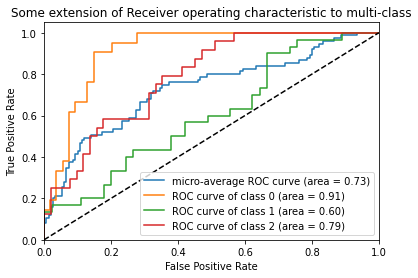

In [106]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]


# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

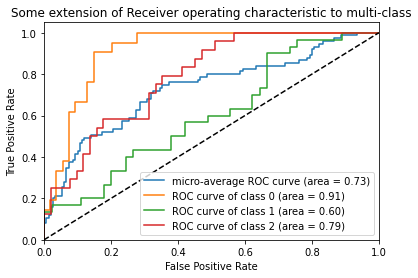

In [105]:
import numpy as np
import matplotlib.pyplot as plt

n_classes=3

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [98]:
# Report top-scoring contradictions

k = 3

def print_pair(claim1, claim2, score):
    print("\nClaim 1")
    print(claim1)
    print("\nClaim 2")
    print(claim2)
    print(f"\nScore: {score:.3f}")
    print("------------")
    

# TODO: Do this on all data

print(f"The top {k} most contradictory pairs are as follows:")
print("===================================================")
eval_data_top_con = eval_data.sort_values(by='BioBERT_Prediction_con', ascending=False).head(k)
for i in range(k):
    pair_i = eval_data_top_con.iloc[i]
    print_pair(pair_i.text1, pair_i.text2, pair_i.BioBERT_Prediction_con)
print("\n\n")
    
print(f"The top {k} most entailing pairs are as follows:")
print("=================================================")
eval_data_top_ent = eval_data.sort_values(by='BioBERT_Prediction_ent', ascending=False).head(k)
for i in range(k):
    pair_i = eval_data_top_ent.iloc[i]
    print_pair(pair_i.text1, pair_i.text2, pair_i.BioBERT_Prediction_ent)
print("\n\n")
    
print(f"The top {k} most neutral pairs are as follows:")
print("===============================================")
eval_data_top_neu = eval_data.sort_values(by='BioBERT_Prediction_neu', ascending=False).head(k)
for i in range(k):
    pair_i = eval_data_top_neu.iloc[i]
    print_pair(pair_i.text1, pair_i.text2, pair_i.BioBERT_Prediction_neu)
print("\n\n")


The top 3 most contradictory pairs are as follows:

Claim 1
as the world awaits the results of clinical trials for the anti-viral efficacy of hcq in the treatment of sars-cov2 infection, this large scale, international real-world data network study enables us to consider the safety of the most popular drugs under consideration.

Claim 2
the low cost of chloroquine and hcq could also be an effective strategy to counter covid-19 (especially in patients with diabetes and other co-morbidities in whom mortality is high) in resource constrained and covid-19 overburdened heath care systems in middle-and low-income counties including india.

Score: 0.997
------------

Claim 1
as the world awaits the results of clinical trials for the anti-viral efficacy of hcq in the treatment of sars-cov2 infection, this large scale, international real-world data network study enables us to consider the safety of the most popular drugs under consideration.

Claim 2
the measures of restrained advocacy for pote

<AxesSubplot:xlabel='BioBERT_Prediction_neu'>

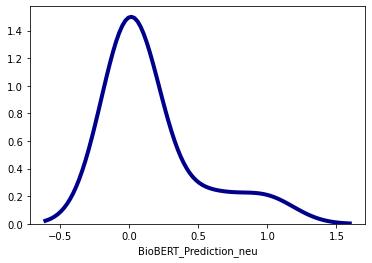

In [92]:
# Report most "found" contradictions by drug mention.

query_drug = "chloroquine"
drug_eval_data = eval_data[eval_data.evaluated_for == query_drug]
#drug_contras_distribution = drug_eval_data.BioBERT_Prediction_neu

import seaborn as sns

# sns.distplot(drug_eval_data.BioBERT_Prediction_neu, hist=True, kde=True, 
#              bins=10, color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 4})

sns.distplot(drug_eval_data.BioBERT_Prediction_neu, hist=False, kde=True, 
             bins=10, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

### Qualitative Evaluation
We will now qualitatively look at a few examples.

In [ ]:
output_data = pd.read_excel('/kaggle/input/drug-individual-claims-similarity-annotated/drug_individual_claims_similarity_annotated.xlsx',sheet_name='drug_individual_claims_similari')
output_data = output_data.dropna().reset_index(drop=True)

In [ ]:
ls = []
for i in range(len(output_data)):
    ls.append(str('[CLS]'+output_data.loc[i,'text1']+'[SEP]'+output_data.loc[i,'text2']))
    
test_example = regular_encode(ls, tokenizer, maxlen=MAX_LEN)
predictions = model.predict(test_example)
if method=='1':
    output_data['BioBERT_Prediction'] = [p[0] for p in predictions]
if method=='2':
    output_data['BioBERT_Prediction_con'] = [p[0] for p in predictions]
    output_data['BioBERT_Prediction_ent'] = [p[1] for p in predictions]
    output_data['BioBERT_Prediction_neu'] = [p[2] for p in predictions]

In [ ]:
print(len(output_data))
print(len(output_data.loc[output_data.annotation=='contradiction',:]))
print(len(output_data.loc[output_data.annotation=='entailment',:]))
print(len(output_data.loc[output_data.annotation=='neutral',:]))

In [ ]:
if method=='1':
    print(max(output_data.BioBERT_Prediction))
if method=='2':
    print(max(output_data.BioBERT_Prediction_con))
    print(max(output_data.BioBERT_Prediction_ent))
    print(max(output_data.BioBERT_Prediction_neu))

In [ ]:
if method=='1':
    output_data['label'] = [1 if a=='contradiction' else 0 for a in output_data.annotation]
    output_data['BioBERT_Prediction_class'] = [1 if p>=0.375 else 0 for p in output_data.BioBERT_Prediction]
    
    print('Overall accuracy: '\
      + str(accuracy_score(output_data['label'], output_data['BioBERT_Prediction_class'] )))
    print('Precision: '\
          + str(precision_score(output_data['label'], output_data['BioBERT_Prediction_class'] )))
    print('Recall: '\
          + str(recall_score(output_data['label'], output_data['BioBERT_Prediction_class'] )))
    print('F1 score: '\
          + str(f1_score(output_data['label'], output_data['BioBERT_Prediction_class'] )))

if method=='2':
    output_data['label'] = output_data.annotation
    output_data['BioBERT_Prediction_class'] = output_data[['BioBERT_Prediction_con','BioBERT_Prediction_ent','BioBERT_Prediction_neu']].idxmax(axis=1)
    output_data['BioBERT_Prediction_class'].replace(to_replace={'BioBERT_Prediction_con':'contradiction','BioBERT_Prediction_ent':'entailment','BioBERT_Prediction_neu':'neutral'}\
                                                   ,inplace=True)
    
    print('Overall accuracy: '\
      + str(accuracy_score(output_data['label'], output_data['BioBERT_Prediction_class'] )))
    print('Precision: '\
          + str(precision_score(output_data['label'], output_data['BioBERT_Prediction_class'], average = None)))
    print('Recall: '\
          + str(recall_score(output_data['label'], output_data['BioBERT_Prediction_class'], average = None)))
    print('F1 score: '\
          + str(f1_score(output_data['label'], output_data['BioBERT_Prediction_class'], average = None)))

In [ ]:
output_data.to_csv('bioBERT_Output.csv',header=True)